In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
from vis_tool import walk_through

In [2]:
sns.set_style("whitegrid", {"grid.linestyle": "--"})
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (4, 3)
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 13  # 10
plt.rcParams["axes.grid"] = True
plt.rcParams["legend.loc"] = "best"
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["axes.formatter.offset_threshold"] = 1
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Liberation Serif"]
plt.rcParams["text.usetex"] = True

# Part 1: Individual task learning curves

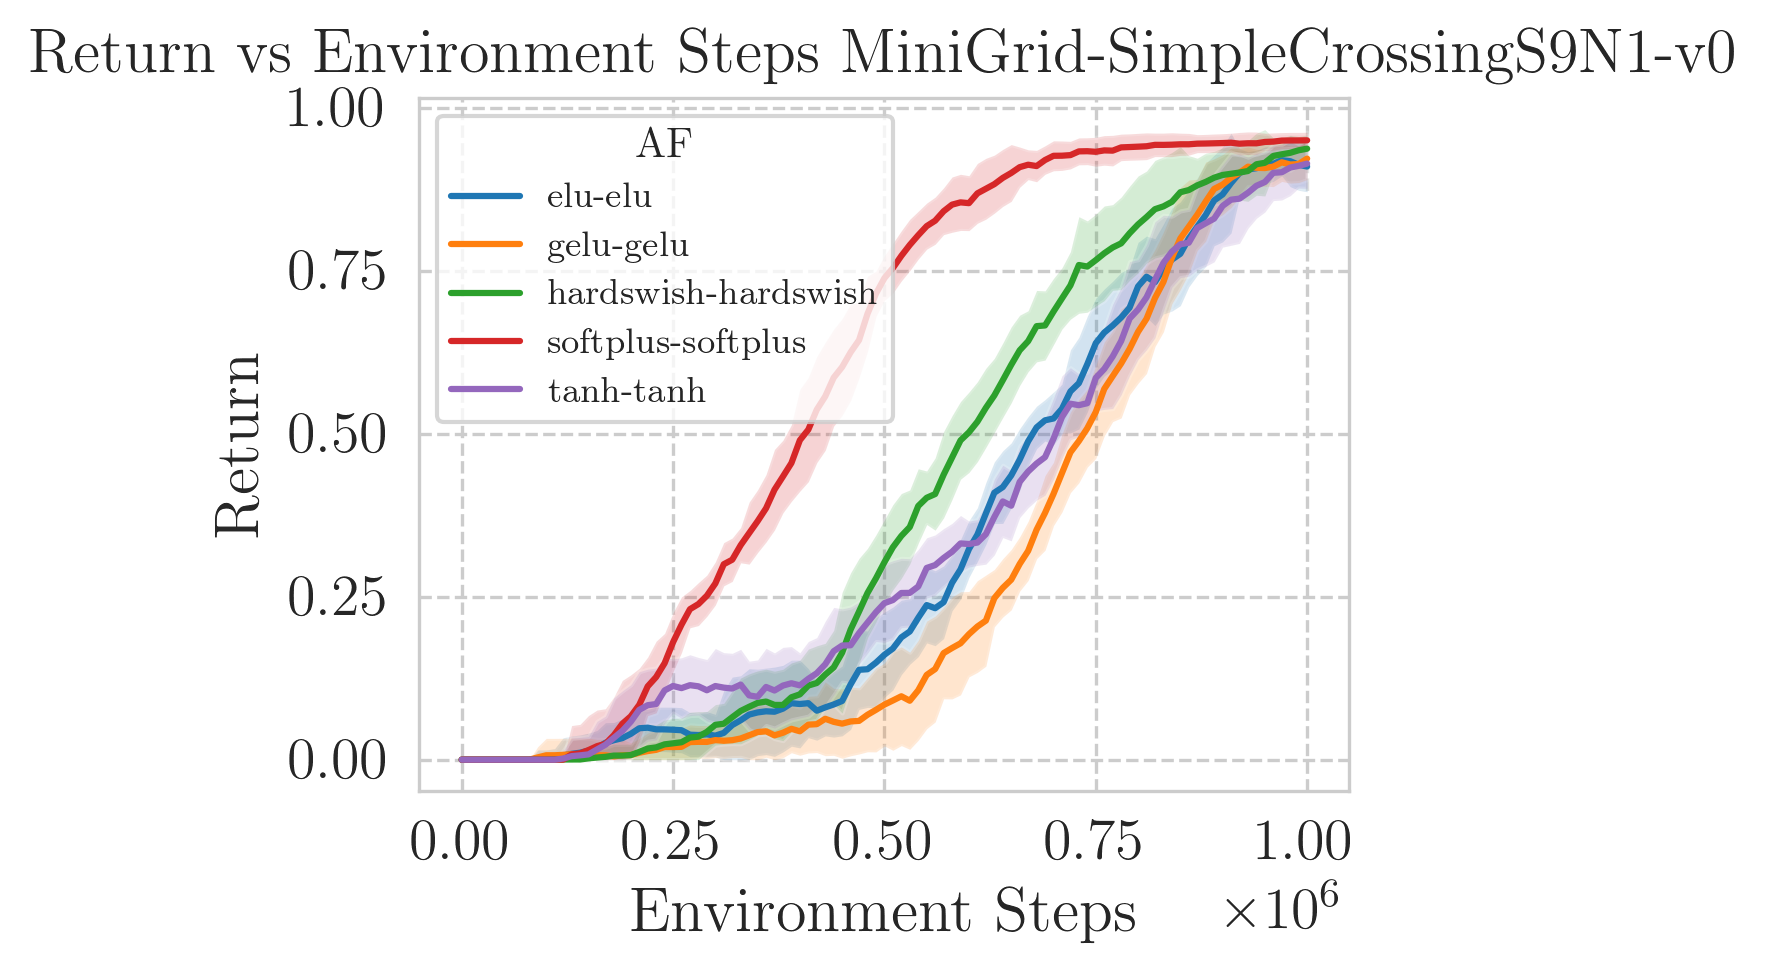

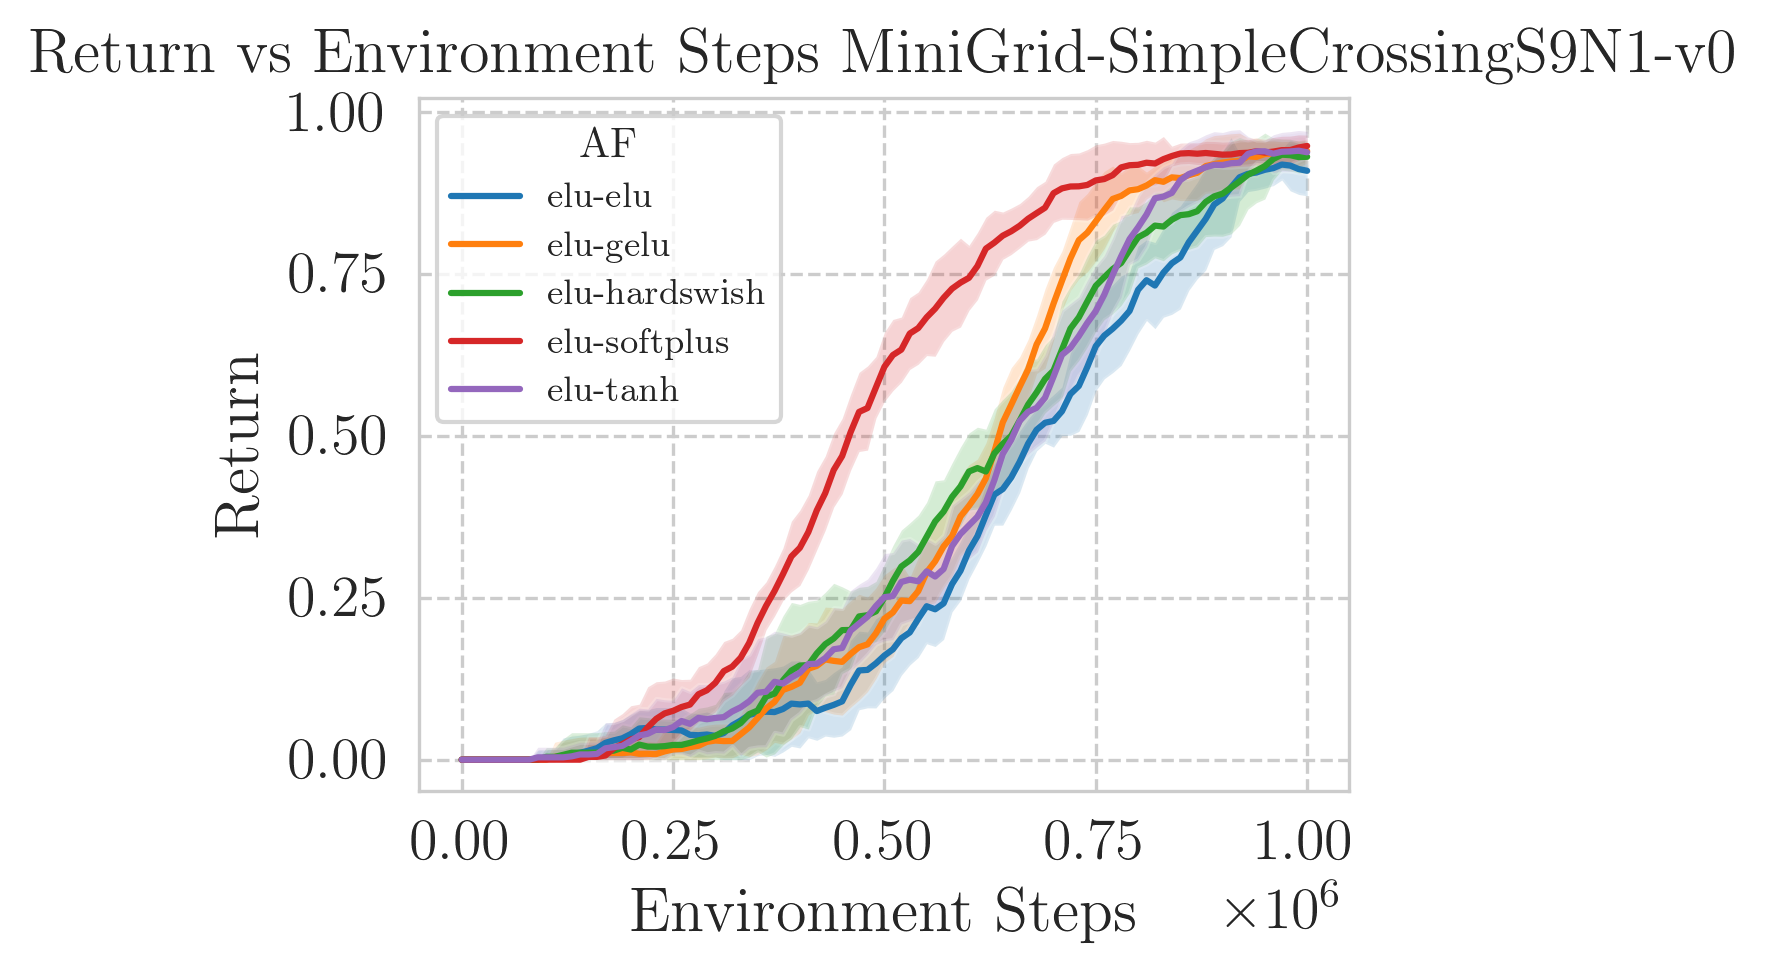

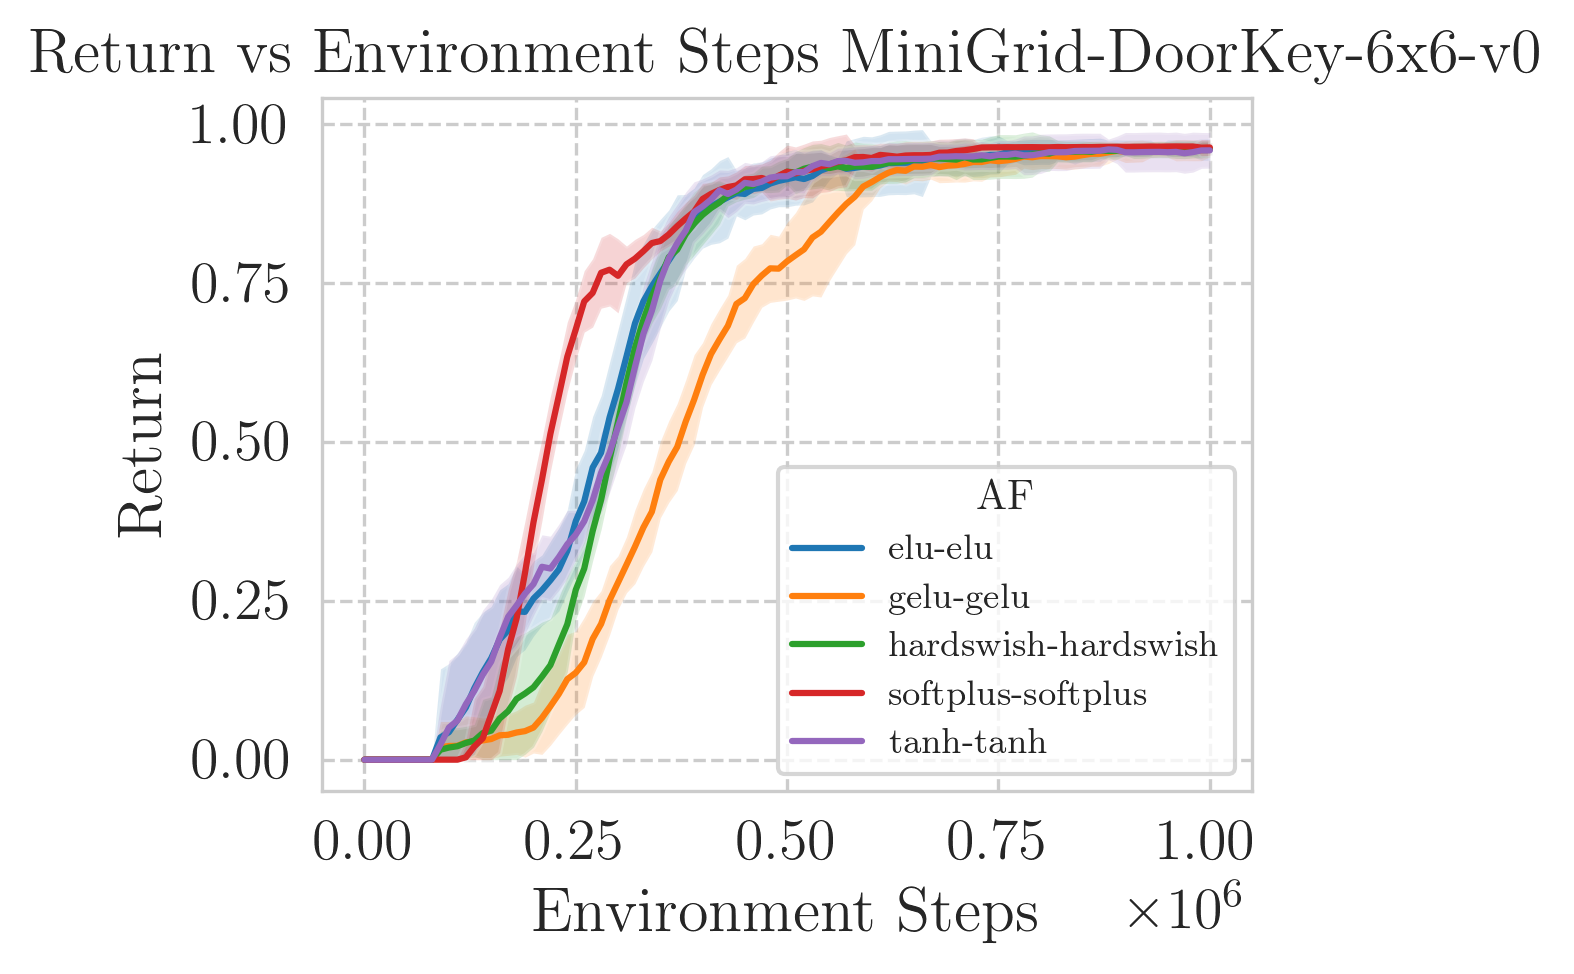

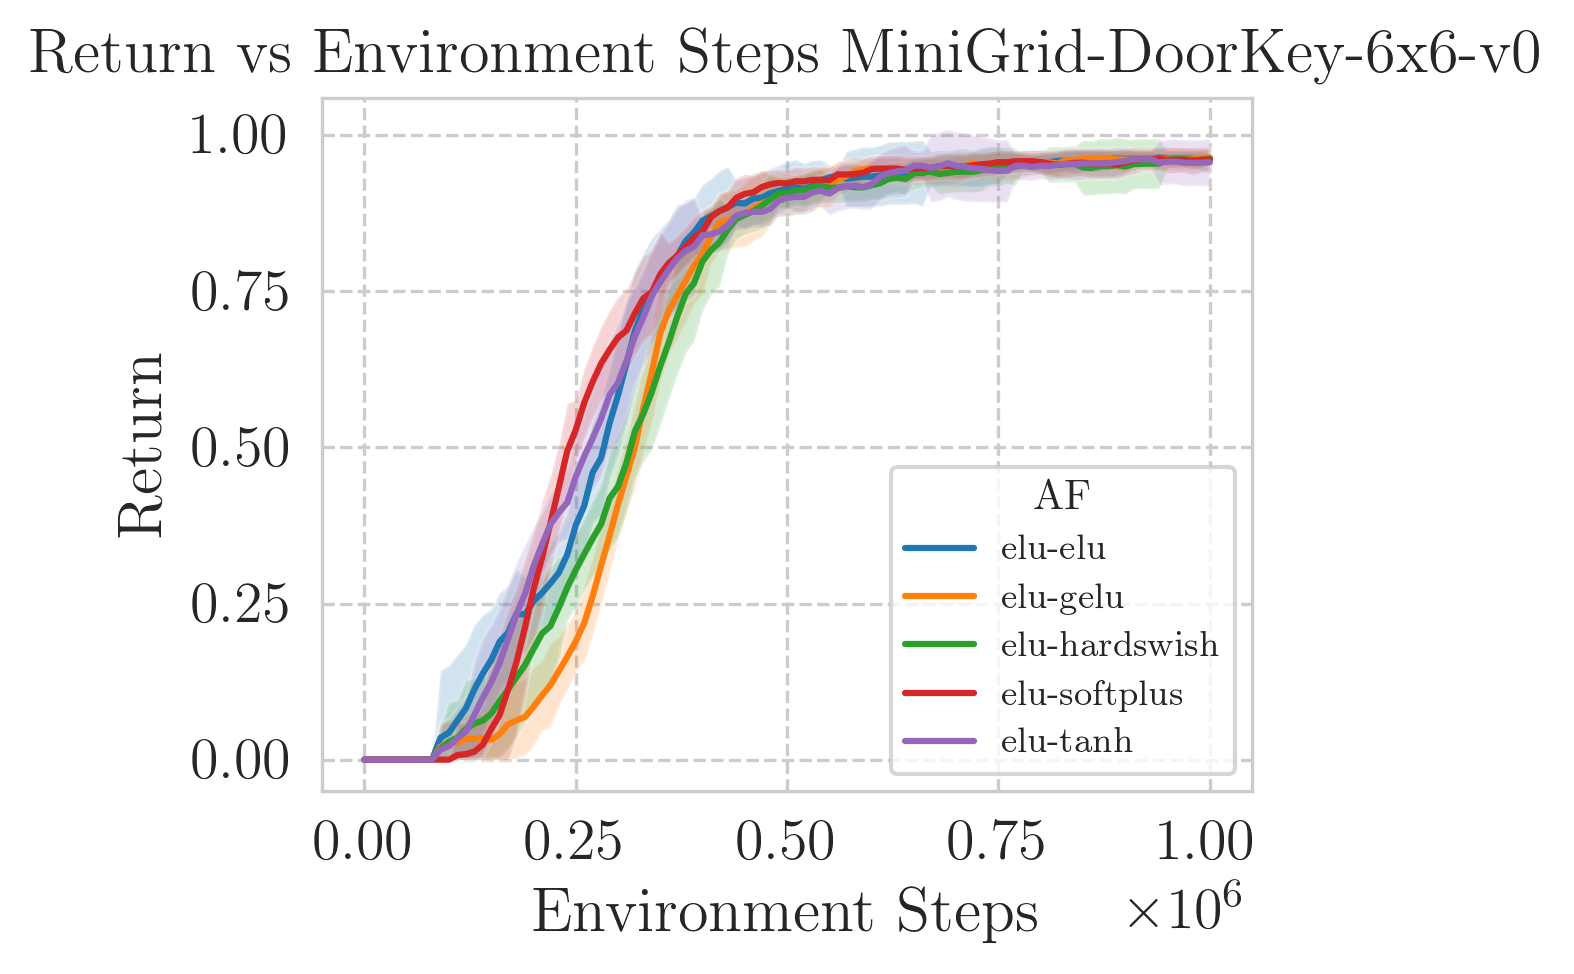

In [18]:

x_label = "environment steps"
metric, y_label, sci_axis = "return", "episode return", "x"
plotting = True

# Define functions
def load_experiment_data(progress_file):
    return pd.read_csv(progress_file)

# Function to aggregate data for a specific af prefix
def aggregate_data_for_af(env_path, af_prefix):
    af_path = os.path.join("logs", env_path)
    seed_folders = [f for f in os.listdir(af_path) if os.path.isdir(os.path.join(af_path, f)) and f.startswith(af_prefix + "_")]
    aggregated_data = []
    for seed_folder in seed_folders:
        progress_file = os.path.join(af_path, seed_folder, "progress.csv")
        progress_data = load_experiment_data(progress_file)
        aggregated_data.append(progress_data)

    concatenated_data = pd.concat(aggregated_data)
    mean_data = concatenated_data.groupby("env_steps")[["return"]].mean()
    std_data = concatenated_data.groupby("env_steps")[["return"]].std()
    return mean_data, std_data
# Loop over environments
for env in [
    "MiniGrid-SimpleCrossingS9N1-v0",
    "MiniGrid-SimpleCrossingS9N1-v0_L2",
    "MiniGrid-DoorKey-6x6-v0",
    "MiniGrid-DoorKey-6x6-v0_L2"
]:
    env_path = os.path.join("logs", env)
    af_prefixes = []
    # Extract af prefixes from config.json files
    for af_folder in os.listdir(env_path):
        if os.path.isdir(os.path.join(env_path, af_folder)):
            if af_folder.split('_')[0] in af_prefixes:
                continue
            else:
                af_prefixes.append(af_folder.split('_')[0])
    af_prefixes.sort()
    for af_prefix in af_prefixes:
        mean_data, std_data = aggregate_data_for_af(env, af_prefix)
        mean_data = mean_data.rolling(window=10).mean().fillna(value=0)
        std_data = std_data.rolling(window=10).std().fillna(value=0)

        plt.plot(np.array(mean_data.index), np.array(mean_data['return']), label=af_prefix)

        lower_bound = np.maximum(mean_data['return'] - std_data['return'], 0)
        upper_bound = mean_data['return'] + std_data['return']
        plt.fill_between(np.array(mean_data.index), lower_bound, upper_bound, alpha=0.2)
        
    env_name = env.split('_')[0]
    plt.xlabel('Environment Steps')
    plt.ylabel('Return')
    plt.title('Return vs Environment Steps ' + env_name)
    plt.legend(title='AF', fontsize='small')
    plt.grid(True)
    plt.show()

# Part 2: Aggregated learning curves

In [53]:
x_label = "environment steps"
# metric, y_label, sci_axis = "return", "episode return", "x"
metric, y_label, sci_axis = "rank-3", "matrix rank", "x"
# metric, y_label, sci_axis = "FPS", "FPS", "x"
# metric, y_label, sci_axis = "zp_loss", "ZP loss", "x"
separate_legend = False  #  True #
tag = "ZP"  # "" #  "AIS" "AIS-P2"  "OP"

hue = (
    # None
    # "aux"
    "aux_optim"
    # "aux_coef"
)
style = (
    None
    # hue
    # "modular"
    # "aux"
    # "aux_optim"
    # "aux_coef"
)


def modular(aux):
    aux_renames = {
        "None": False,
        "ZP": False,
        "OP": False,
        "AIS": True,
        "AIS-P2": True,
    }
    return aux_renames[aux]


aux_renames = {
    "None": "R2D2",
    "ZP": "ZP",
    "OP": "OP",
    "AIS": "RP+OP",
    "AIS-P2": "RP+ZP",
}
optim_names = {
    "online": "ZP (Online)",
    "detach": "ZP (Detached)",
    "ema": "ZP (EMA)",
}


def reduce_algo_to_aux(aux):
    return aux_renames[aux]


def rename_optim(optim, aux):
    if optim in optim_names:
        return optim_names[optim]
    return aux


def query_fn(flags):
    if tag != "":
        if flags["aux"] != tag and flags["aux"] not in ["None", "OP"]:
            return False

    if flags["aux"] == "ZP":
        if hue == "aux_optim":
            return flags["aux_coef"] == 1.0
        else:
            return flags["aux_coef"] == 1.0 and flags["aux_optim"] == "ema"
    elif flags["aux"] == "OP":
        return flags["aux_coef"] == 0.01
    elif flags["aux"] == "AIS-P2":
        return flags["aux_coef"] == 1.0 and flags["aux_optim"] == "ema"
    elif flags["aux"] == "AIS":
        return flags["aux_coef"] == 1.0
    return True


df_alltasks = []
min_num_runs = 100

for env in [
    "MiniGrid-SimpleCrossingS9N1-v0",
    "MiniGrid-SimpleCrossingS9N1-v0_L2",
    "MiniGrid-SimpleCrossingS9N2-v0",
    "MiniGrid-SimpleCrossingS9N3-v0",
    "MiniGrid-SimpleCrossingS11N5-v0",
    "MiniGrid-LavaCrossingS9N1-v0",
    "MiniGrid-LavaCrossingS9N2-v0",
    "MiniGrid-LavaCrossingS9N3-v0",
    "MiniGrid-LavaCrossingS11N5-v0",
    "MiniGrid-Unlock-v0",
    "MiniGrid-UnlockPickup-v0",
    "MiniGrid-DoorKey-5x5-v0",
    "MiniGrid-DoorKey-6x6-v0",
    "MiniGrid-DoorKey-8x8-v0",
    "MiniGrid-KeyCorridorS3R1-v0",
    "MiniGrid-KeyCorridorS3R2-v0",
    "MiniGrid-KeyCorridorS3R3-v0",
    "MiniGrid-ObstructedMaze-1Dl-v0",
    "MiniGrid-ObstructedMaze-1Dlh-v0",
    "MiniGrid-MultiRoom-N2-S4-v0",
    "MiniGrid-MultiRoom-N4-S5-v0",
]:
    end = 1.5e6
    env_tag = env
    path = "logs/" + env_tag

    df = walk_through(
        path,
        metric,
        query_fn,
        start=0,
        end=end,
        steps=400,
        cutoff=0.75 if "MultiRoom-N2-S4" in env else 0.95,
        extrapolate=True,
        window=10,
    )
    df = df.fillna(False)

    # custom functions to add, reduce, rename flags
    df[x_label] = df["env_steps"]
    df["modular"] = df.apply(lambda row: modular(row["aux"]), axis=1)
    df["aux"] = df.apply(lambda row: reduce_algo_to_aux(row["aux"]), axis=1)
    df["aux_optim"] = df.apply(
        lambda row: rename_optim(row["aux_optim"], row["aux"]), axis=1
    )
    if metric in df:
        df[y_label] = df[metric]
    # print stats of runs
    if style is None or style == hue:
        num_runs = df.drop_duplicates(subset=["logdir"]).groupby([hue]).size()
    else:
        num_runs = df.drop_duplicates(subset=["logdir"]).groupby([hue, style]).size()
    print(num_runs)
    min_num_runs = min(min_num_runs, num_runs.min())

    df_alltasks.append(df)

### transform the dataframe into a dictionary
result = {}

for i, df_pertask in enumerate(df_alltasks):
    # Group by 'aux' column
    for aux_value, aux_group in df_pertask.groupby(hue):
        # For each 'aux', initialize a list to collect arrays
        aux_arrays = []

        # Group by 'logdir' (run) within each 'aux' group
        for log_dir_value, log_dir_group in aux_group.groupby("logdir"):
            # Sort by 'env_steps' and get the 'return' values as a numpy array
            sorted_group = log_dir_group.sort_values(by=x_label)
            run_array = sorted_group[metric].to_numpy()
            # Append the array to the list
            aux_arrays.append(run_array)

            if (
                len(aux_arrays) >= min_num_runs
            ):  # select the first runs to align with num_runs
                break

        # Convert the list of arrays to a 2D numpy array
        aux_matrix = np.array(aux_arrays)

        if i == 0:
            result[aux_value] = np.empty(
                (aux_matrix.shape[0], len(df_alltasks), aux_matrix.shape[1])
            )
        # Assign the 2D array to the corresponding layer in the 3D array (num_runs, num_tasks, env_steps)
        result[aux_value][:, i, :] = aux_matrix

print(result)

logs/MiniGrid-SimpleCrossingS9N1-v0/gelu_3182723-196657 150 1500000
!!incomplete csv logs/MiniGrid-SimpleCrossingS9N1-v0/softplus_3188833-109191 90000 

logs/MiniGrid-SimpleCrossingS9N1-v0/tanh_3182724-125450 150 1500000

 in total: 2
aux_optim
R2D2    2
dtype: int64

 in total: 0


ValueError: No objects to concatenate

In [ ]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices across all 200 million frames, each of which is of size
# `(num_runs x num_games x 200)` where scores are recorded every million frame.
frames = np.array([0, 40, 80, 120, 160, 200, 240, 280, 320, 360, 400 - 1])
selected_result = {
    algorithm: score[:, :, frames] for algorithm, score in result.items()
}  # as computing IQM CI is very slow
iqm = lambda scores: np.array(
    [metrics.aggregate_iqm(scores[..., frame]) for frame in range(scores.shape[-1])]
)
iqm_scores, iqm_cis = rly.get_interval_estimates(selected_result, iqm, reps=50000)

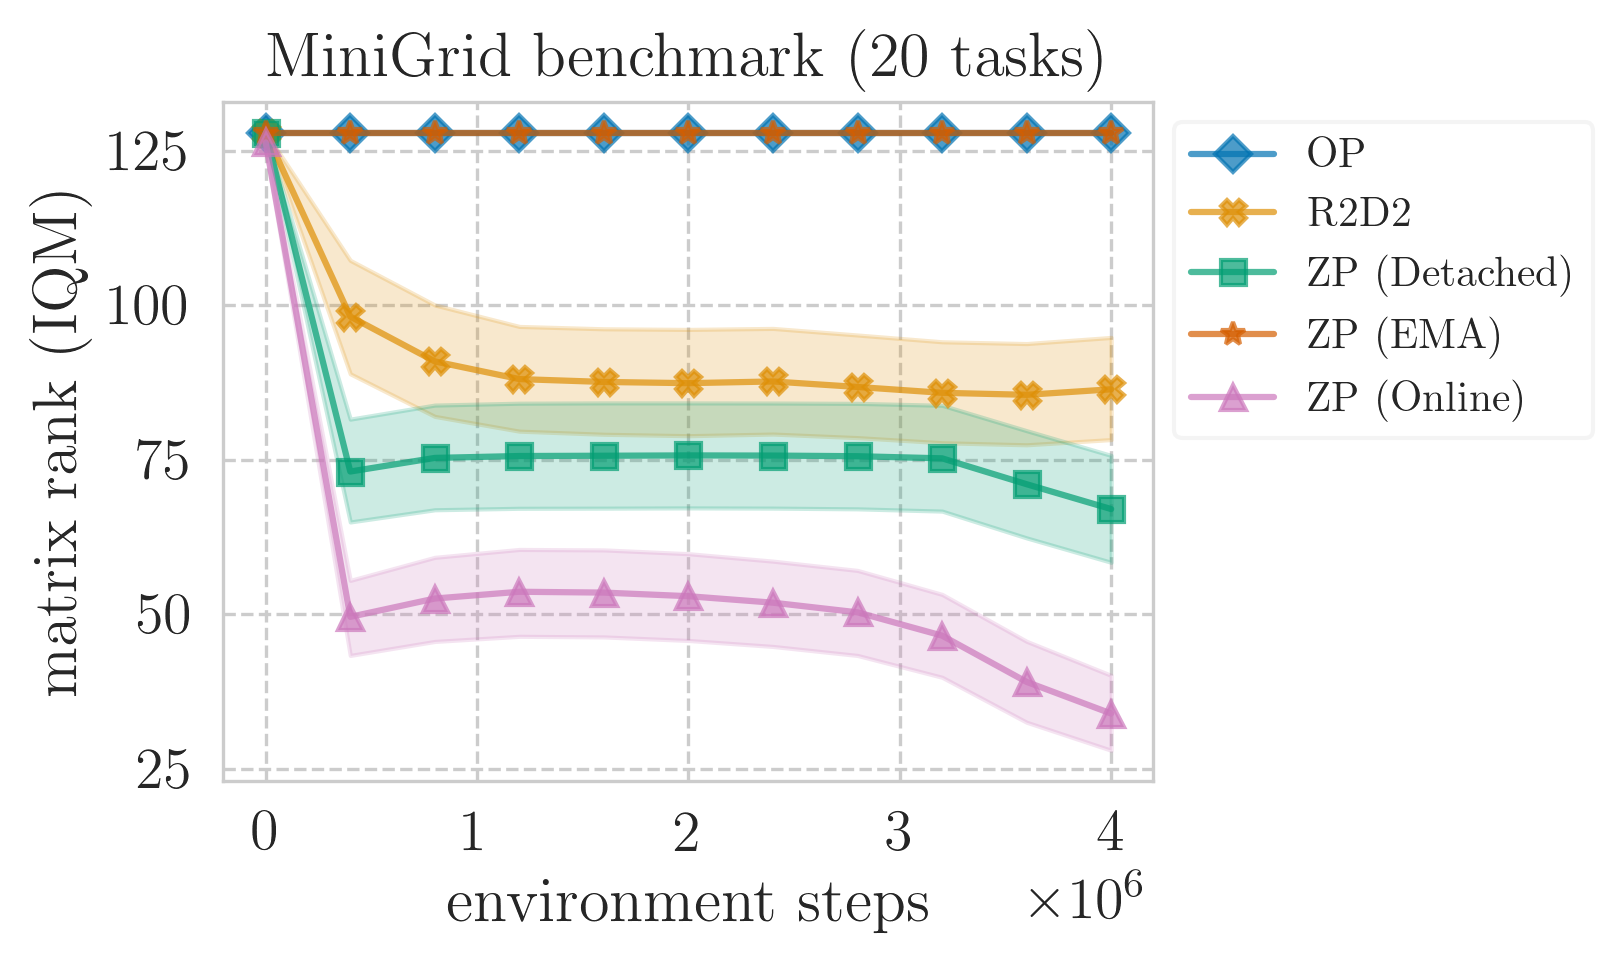

In [ ]:
algorithms = list(result.keys())
color_palette = sns.color_palette("colorblind", n_colors=len(algorithms))
colors = dict(zip(algorithms, color_palette))
# by default, it is always 'o'
if "rank" in metric:
    marker_list = ["D", "X", "s", "*", "^", "v"]
    markers = dict(zip(algorithms, marker_list))
    plt.rcParams["legend.fontsize"] = 10
else:
    plt.rcParams["legend.fontsize"] = 13

real_frames = frames.copy()
real_frames[-1] = 400
real_frames = real_frames * end / 400

for algorithm in algorithms:
    metric_values = iqm_scores[algorithm]
    lower, upper = iqm_cis[algorithm]
    plt.plot(
        real_frames,
        metric_values,
        color=colors[algorithm],
        marker=markers[algorithm] if "rank" in metric else "o",
        label=algorithm,
        alpha=0.7,
    )
    plt.fill_between(
        real_frames, y1=lower, y2=upper, color=colors[algorithm], alpha=0.2
    )


plt.ticklabel_format(axis=sci_axis, style="sci", scilimits=(0, 0))  # default [-5, 6]
if "return" in metric or "success" in metric:
    plt.ylim(top=1.0)
plt.legend(framealpha=0.2, bbox_to_anchor=(1, 1))

plt.xlabel(x_label)
plt.ylabel(y_label + " (IQM)")
plt.title("MiniGrid benchmark (20 tasks)")
plt.savefig(
    f"plts/agg_{tag}_{metric}_{hue}_{style}.pdf",
    bbox_inches="tight",
    pad_inches=0.03,
)  # default 0.1
plt.show()